# Rings Profile
This notebook contains code to analyze the rings data, in order to check if the data is in order and its distributions.

In [1]:
from lzt_utils.dataset import LztDataset
from lzt_utils.constants import N_RINGS
from lzt_utils.utils import set_logger
import lzt_utils.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import ROOT
import numpy as np
import pandas as pd
import logging
from tqdm import tqdm


Module libc not found.


In [2]:
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ATLAS)
set_logger()
mpl.rc('text', usetex = True)

# Load data

In [3]:
lzt_data = Path.home() / 'ext_data' / 'lorenzetti'
output_dir = lzt_data / 'profiles' / 'boosted-lorenzetti-2025-04-18' / 'rings_profile'
output_dir.mkdir(exist_ok=True, parents=True)
datasets = {}
datasets['zee'] = {
    'ds': LztDataset.from_dir(
        lzt_data / 'v2.1.0' / 'user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_Zee'
    ),
    'color': 'blue',
    'label': '$Z \\to ee$',
}

datasets['jf17'] = {
    'ds': LztDataset.from_dir(
        lzt_data / 'v2.1.0' / 'user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_JF17'
    ),
    'color': 'red',
    'label': 'Jets w/ $E \\geq 17 \\: GeV$'
}

datasets

{'zee': {'ds': LztDataset(path=/root/ext_data/lorenzetti/v2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_Zee, label=Z->ee),
  'color': 'blue',
  'label': '$Z \\to ee$'},
 'jf17': {'ds': LztDataset(path=/root/ext_data/lorenzetti/v2.1.0/user.joao.pinto.mc25_13TeV.250401.Pythia8EvtGen_JF17, label=Jets et > 17GeV),
  'color': 'red',
  'label': 'Jets w/ $E \\geq 17 \\: GeV$'}}

In [4]:
def load_data_from_aod(dataset: LztDataset, n_entries: int = -1) -> pd.DataFrame:
    rings_info = []
    iterator = tqdm(enumerate(dataset.aod_tchain),
                    desc='Processing events', unit=' events')
    if n_entries < 0:
        n_entries = np.inf
    for entry, aod_event in iterator:
        if entry >= n_entries:
            break
        event_number = aod_event.EventInfoContainer_Events[0].eventNumber
        for iring, rings_data in enumerate(aod_event.CaloRingsContainer_Rings):
            if rings_data.cluster_link >= len(aod_event.CaloClusterContainer_Clusters):
                logging.warning(f'{entry} - Event {event_number} - '
                                f'iring {iring} - Cluster link {rings_data.cluster_link} out of range')
                continue
            cluster_data = aod_event.CaloClusterContainer_Clusters[rings_data.cluster_link]
            record = {
                'event_number': event_number,
                'rings_size': len(rings_data.rings),
                'cl_eta': cluster_data.eta,
                'cl_phi': cluster_data.phi,
            }
            for i, ring in enumerate(rings_data.rings):
                record[f'ring_{i}'] = ring
            rings_info.append(record)
    rings_info = pd.DataFrame.from_dict(rings_info)
    return rings_info

In [5]:
def load_data_from_ntuple(dataset: LztDataset, n_entries: int = -1) -> pd.DataFrame:
    rings_info = []
    iterator = tqdm(enumerate(dataset.ntuple_tchain))
    if n_entries < 0:
        n_entries = np.inf
    for entry, event in iterator:
        if entry >= n_entries:
            break
        record = {
            'event_number': event.EventNumber,
            'rings_size': len(event.cl_rings),
            'cl_eta': event.cl_eta,
            'cl_phi': event.cl_phi,
        }
        for i, ring in enumerate(event.cl_rings):
            record[f'ring_{i}'] = ring
        rings_info.append(record)
    rings_info = pd.DataFrame.from_dict(rings_info)
    return rings_info

In [6]:
data_src = 'aod'
rewrite_cache = False
n_entries = -1
for name, dataset_info in datasets.items():
    output_filepath = output_dir / f'rings_info_{name}_{data_src}.parquet.gzip'
    if not rewrite_cache and output_filepath.exists():
        logging.info(f'Loading cached file for {name}')
        rings_info = pd.read_parquet(output_filepath)
    else:
        logging.info(f'Loading {name}')
        if data_src =='aod':
            rings_info = load_data_from_aod(dataset_info['ds'], n_entries)
        elif data_src == 'ntuple':
            rings_info = load_data_from_ntuple(dataset_info['ds'], n_entries)
        else:
            raise ValueError(f"Unknown data source: {data_src}")
        logging.info('Writing rings_info to parquet')
        rings_info.to_parquet(output_filepath,
                              compression='gzip')
    datasets[name]['rings_info'] = rings_info

2025-04-21 11:19:03 | INFO | root | 3318279325 | 7 | Loading cached file for zee
2025-04-21 11:19:03 | INFO | root | 3318279325 | 7 | Loading cached file for jf17


# Check number of vector entries

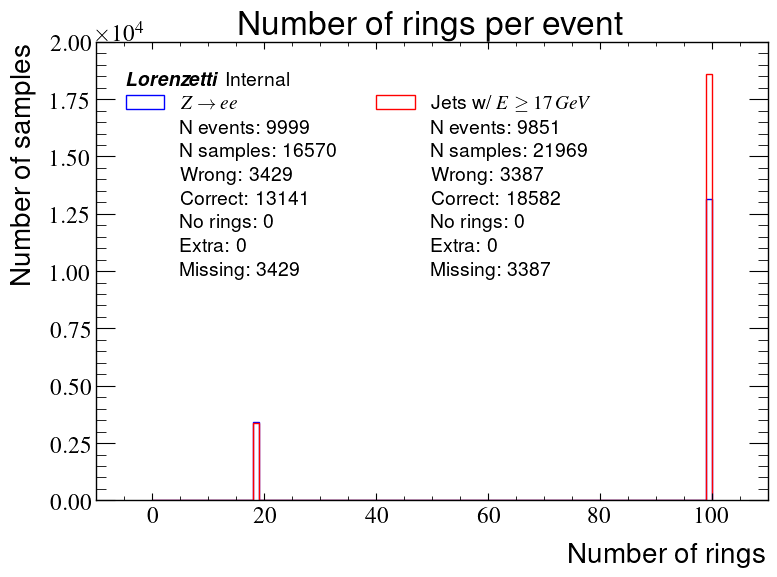

In [7]:
fig, ax = plt.subplots()
max_ring_size = -1
bins = np.arange(201)
for name, dataset_info in datasets.items():
    rings_info = dataset_info['rings_info']
    current_max_ring_size = rings_info['rings_size'].max()
    if current_max_ring_size > max_ring_size:
        max_ring_size = current_max_ring_size
    ax.hist(rings_info['rings_size'],
            bins=np.arange(current_max_ring_size + 1),
            histtype='step',
            color=dataset_info['color'],
            label=dataset_info['label'])
    # ax.grid(linestyle='--', alpha=0.5)
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
    ax.plot([], [], ' ',
            label=f'Wrong: {(rings_info["rings_size"] != N_RINGS).sum()}')
    ax.plot([], [], ' ',
            label=f'Correct: {(rings_info["rings_size"] == N_RINGS).sum()}')
    ax.plot([], [], ' ',
            label=f'No rings: {(rings_info["rings_size"] == 0).sum()}')
    ax.plot([], [], ' ',
            label=f'Extra: {(rings_info["rings_size"] > N_RINGS).sum()}')
    ax.plot([], [], ' ',
            label=f'Missing: {(rings_info["rings_size"] < N_RINGS).sum()}')
ax.set(
    xlabel='Number of rings',
    ylabel='Number of samples',
    title='Number of rings per event',
    xlim=(-10, max_ring_size + 10)
)
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          )
fig.tight_layout()
fig.savefig(output_dir / f'number_of_rings_{data_src}.png', dpi=300)

/tmp/ipykernel_52140/3547811672.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lower_ax.legend(alignment='left',


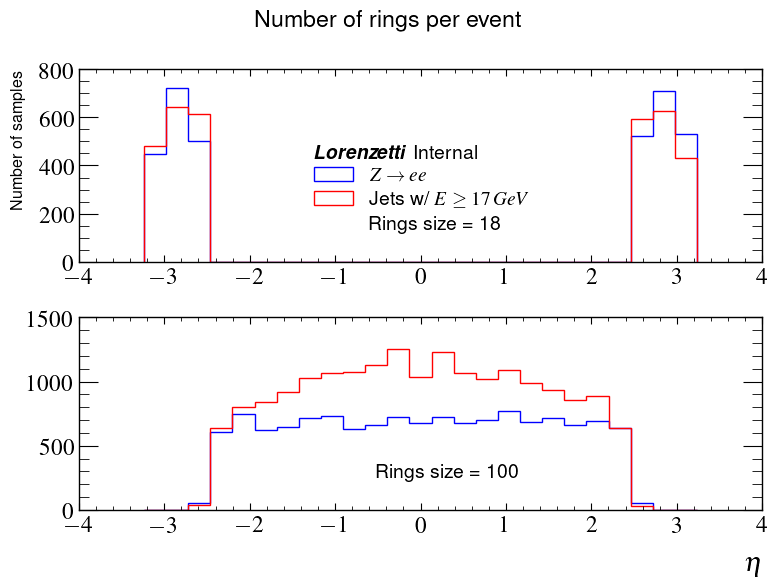

In [8]:
fig, axes = plt.subplots(2,1)
top_ax, lower_ax = axes
top_size = 18
lower_size = 100
for i, (name, dataset_info) in enumerate(datasets.items()):
    rings_info = dataset_info['rings_info']
    top_counts, top_bins, _ = top_ax.hist(
        rings_info.loc[rings_info['rings_size'] == top_size, 'cl_eta'],
        bins=25,
        histtype='step',
        color=dataset_info['color'],
        label=dataset_info['label'])
    # ax.grid(linestyle='--', alpha=0.5)
    if i == 1:
        top_ax.plot([], [], ' ',
                label=f'Rings size = {top_size}')
    top_ax.set_ylabel('Number of samples', fontsize='small')
    top_ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
                alignment='left',
                facecolor='white',
                ncols=1,
    )
    lower_ax.hist(
        rings_info.loc[rings_info['rings_size'] == lower_size, 'cl_eta'],
        bins=top_bins,
        histtype='step',
        color=dataset_info['color']
    )
    if i == 1:
        lower_ax.plot([], [], ' ',
                label=f'Rings size = {lower_size}')
    lower_ax.legend(alignment='left',
                facecolor='white',
                ncols=1,
    )
    lower_ax.set(
        xlabel='$\\eta$',
    )
fig.suptitle('Number of rings per event')
fig.tight_layout()
fig.savefig(output_dir / f'number_of_rings_multi_plot_{data_src}.png', dpi=300)

# Check $\mu \pm \sigma$

## Default

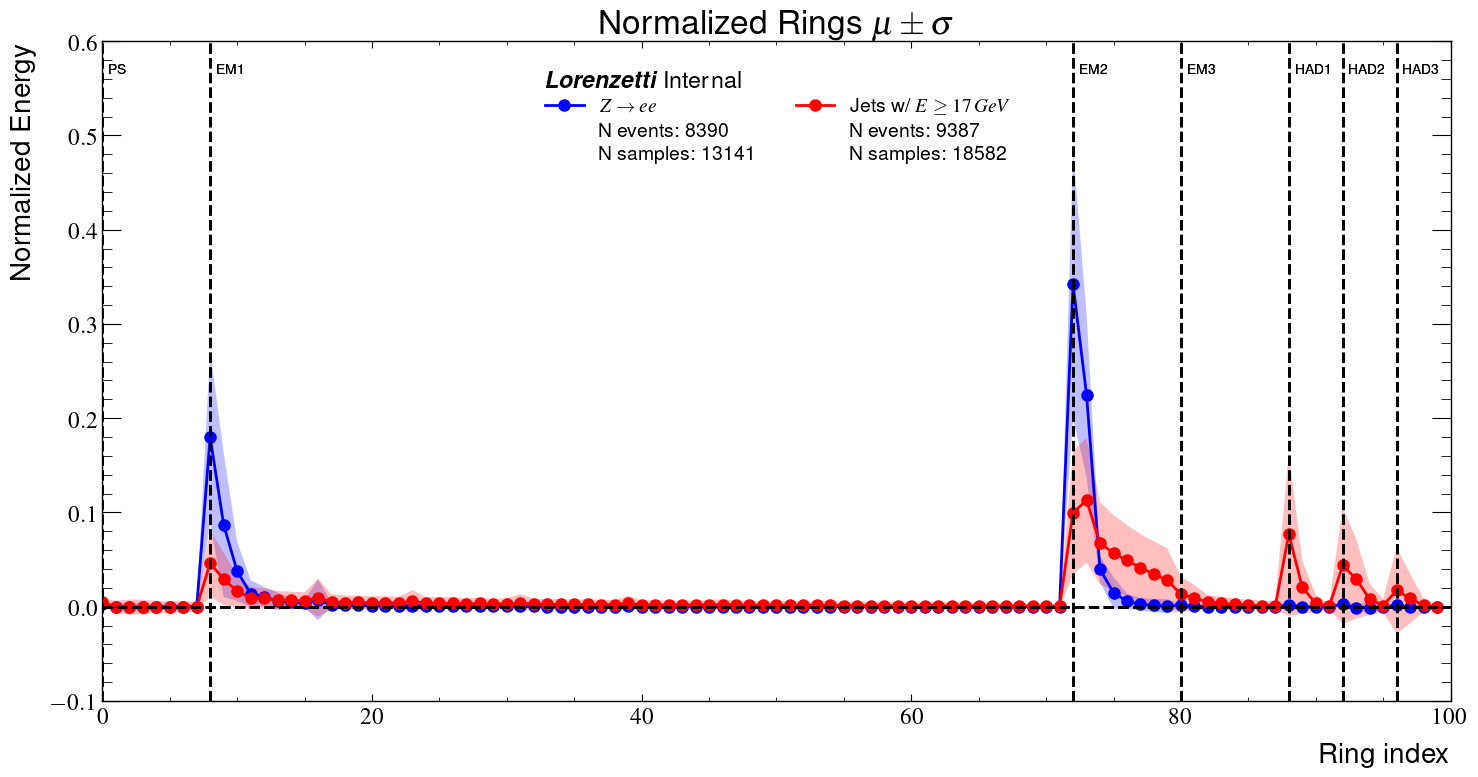

In [9]:
normalize=True
fig, ax = plt.subplots(figsize=(15, 8))
for name, dataset_info in datasets.items():
    rings_info = dataset_info['rings_info']
    rings_info = rings_info[rings_info['rings_size'] == N_RINGS]
    rings_columns = [f'ring_{i}' for i in range(rings_info.shape[-1]-4)]
    _ = lplt.plot_rings_profile(
        rings_info[rings_columns],
        ax=ax,
        normalize=normalize,
        color=dataset_info['color'],
        ax_set_kwargs=dict(
            ylabel='Normalized Energy' if normalize else 'Energy [MeV]',
        ),
        label=dataset_info['label']
    )
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          title_fontproperties=dict(size='large'),
          )
fig.tight_layout()
if normalize:
    figname = f'mean_rings_normalized_{data_src}.png'
else:
    figname = f'mean_rings_{data_src}.png'
# fig.savefig(output_dir / figname, dpi=300)

# All Rings

2025-04-21 11:23:45 | INFO | root | 3793691063 | 4 | Plotting rings for zee


2025-04-21 11:23:49 | INFO | root | 3793691063 | 4 | Plotting rings for jf17


/tmp/ipykernel_52140/3793691063.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()
/tmp/ipykernel_52140/3793691063.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(output_dir / figname, dpi=300)
/tmp/ipykernel_52140/3793691063.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(output_dir / figname, dpi=300)
/opt/lorenzetti-python/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/lorenzetti-python/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


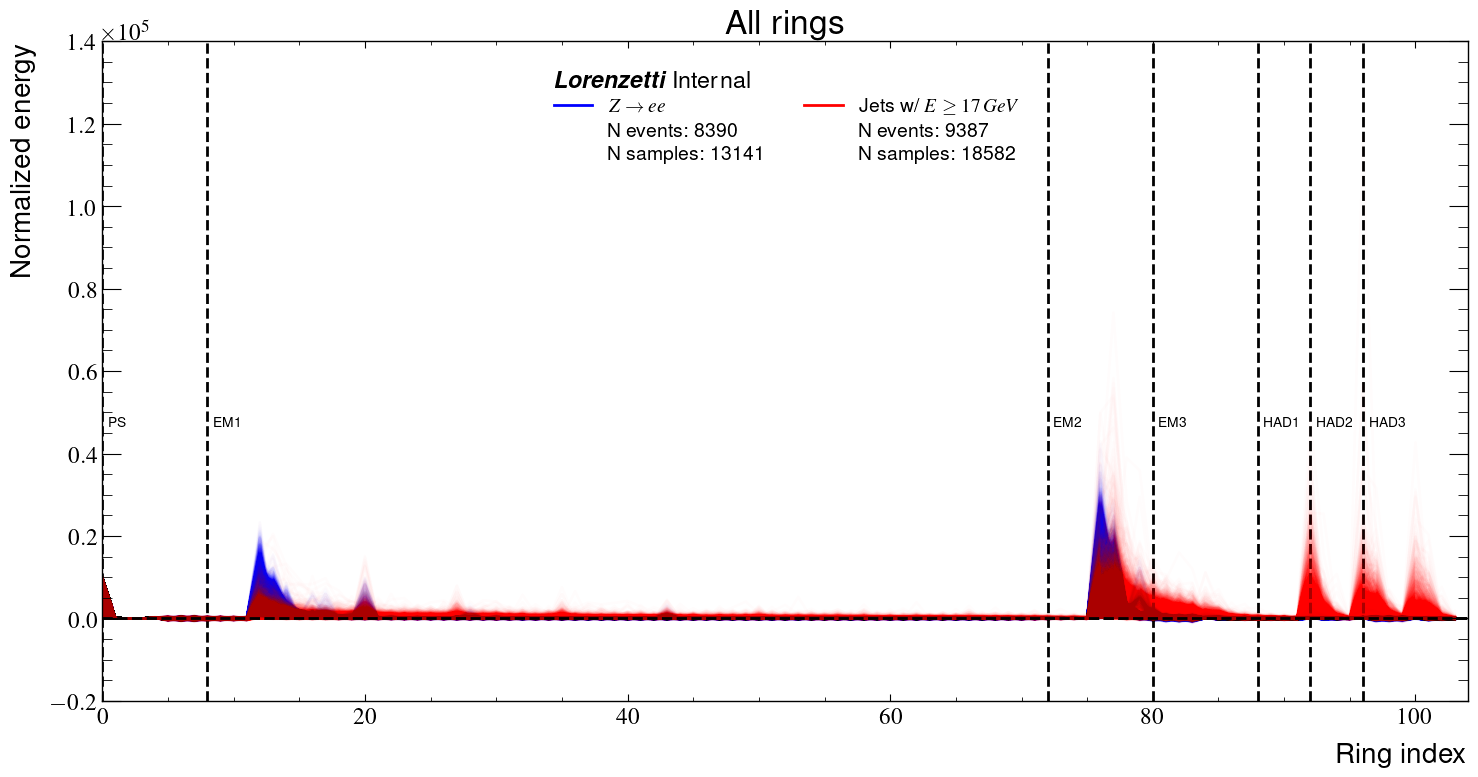

: 

In [ ]:
normalize=False
fig, ax = plt.subplots(figsize=(15, 8))
for i, (name, dataset_info) in enumerate(datasets.items()):
    logging.info(f'Plotting rings for {name}')
    x = np.arange(N_RINGS)
    rings_info = dataset_info['rings_info']
    rings_info = rings_info[rings_info['rings_size'] == N_RINGS]
    rings_columns = [f'ring_{i}' for i in range(rings_info.shape[-1]-2)]
    lplt.plot_all_rings(
        rings_info, ax,
        normalize=normalize,
        plot_kwargs=dict(
            color=dataset_info['color'],
            label=dataset_info['label'],
            alpha=0.01),
        add_rings_labels=(i==0))
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
    del rings_info
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          title_fontproperties=dict(size='large'),
          )
fig.tight_layout()
if normalize:
    figname = f'all_rings_normalized_{data_src}_zee.png'
else:
    figname = f'all_rings_{data_src}.png'
fig.savefig(output_dir / figname, dpi=300)